In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
# Import train & test data 
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")
gender_submission = pd.read_csv("/kaggle/input/titanic/gender_submission.csv") # example of what a submission should look like

## Understand shape of the data (histograms, box plots etc)
    .info(), .describe(), historgrams, boxplots, value counts for catgroicals

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


<AxesSubplot:ylabel='Frequency'>

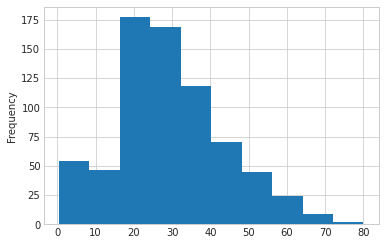

In [6]:
train.Age.plot.hist()

Survival: 0 = No, 1 = Yes

pclass (Ticket class): 1 = 1st, 2 = 2nd, 3 = 3rd

sex: Sex

Age: Age in years

sibsp: number of siblings/spouses aboard the Titanic

parch: number of parents/children aboard the Titanic

ticket: Ticket number

fare: Passenger fare

cabin: Cabin number

embarked: Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

In [7]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<AxesSubplot:>

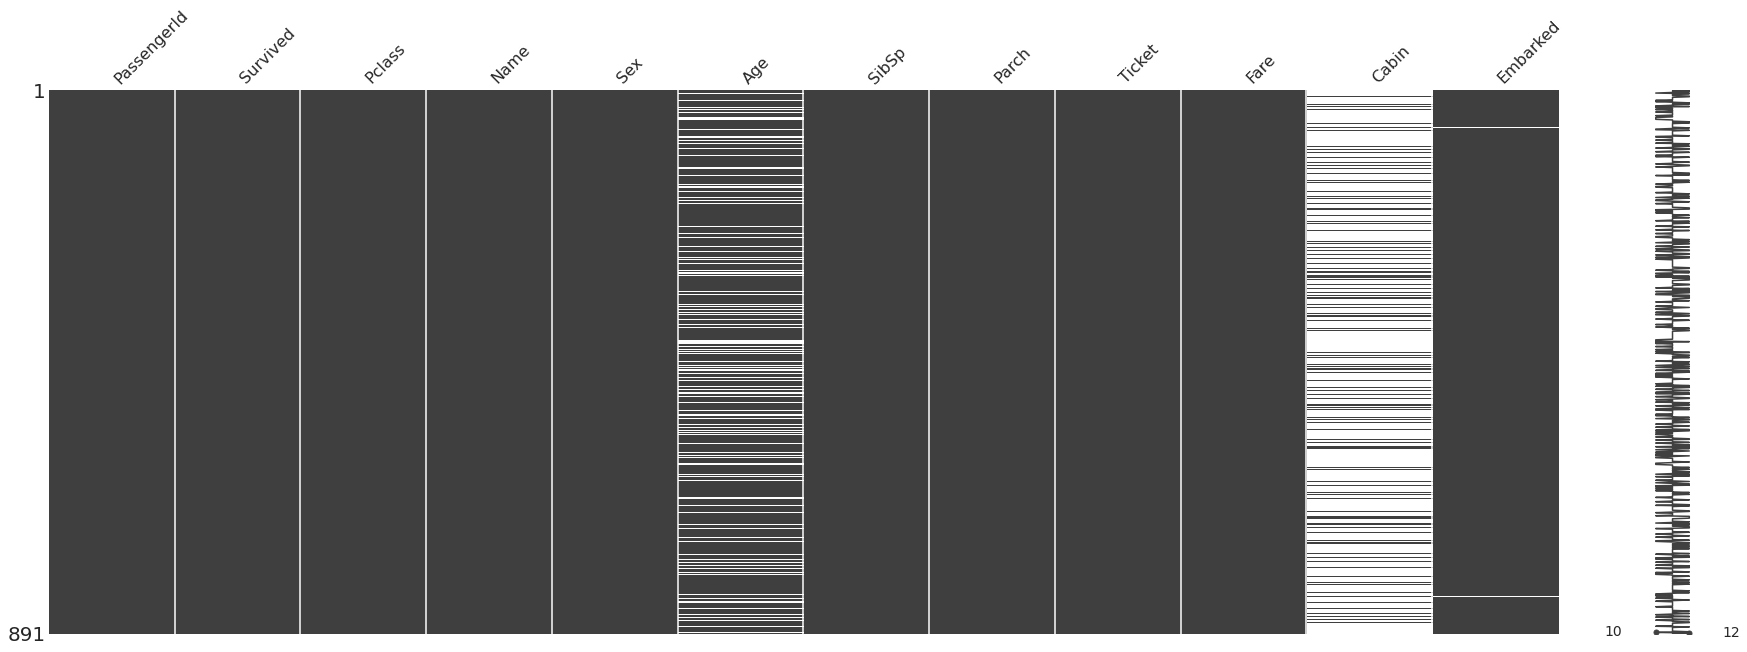

In [8]:
# Plot graphic of missing values
missingno.matrix(train, figsize = (30,10))

In [9]:
# Alternatively, you can see the number of missing values like this
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### To perform our data analysis, let's create two new dataframes
We'll create one for exploring discretised continuous variables (continuous variables which have been sorted into some kind of category) and another for exploring continuous variables.



In [10]:
df_bin = pd.DataFrame() # for discretised continuous variables
df_con = pd.DataFrame() # for continuous variables
df_bin_test = pd.DataFrame()

In [11]:
# Different data types in the dataset
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

#### Let's explore each of these features individually

In [12]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


0    549
1    342
Name: Survived, dtype: int64


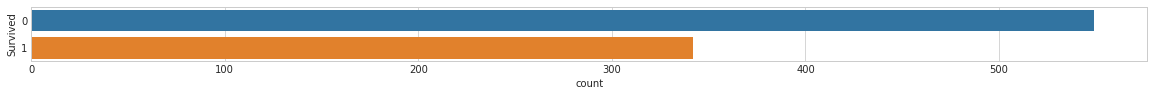

In [13]:
# survived

# How many people survived?
fig = plt.figure(figsize=(20,1))
sns.countplot(y='Survived', data=train);
print(train.Survived.value_counts())

In [14]:
# Let's add this to our subset dataframes
df_bin['Survived'] = train['Survived']
df_con['Survived'] = train['Survived']
df_bin.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [15]:
def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20, 5), use_bin_df=False):
    """
    Function to plot counts and distributions of a label variable and 
    target variable side by side.
    ::param_data:: = target dataframe
    ::param_bin_df:: = binned dataframe for countplot
    ::param_label_column:: = binary labelled column
    ::param_target_column:: = column you want to view counts and distributions
    ::param_figsize:: = size of figure (width, height)
    ::param_use_bin_df:: = whether or not to use the bin_df, default False
    """
    if use_bin_df: 
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=bin_df);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});
    else:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=data);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});

#### PClass

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


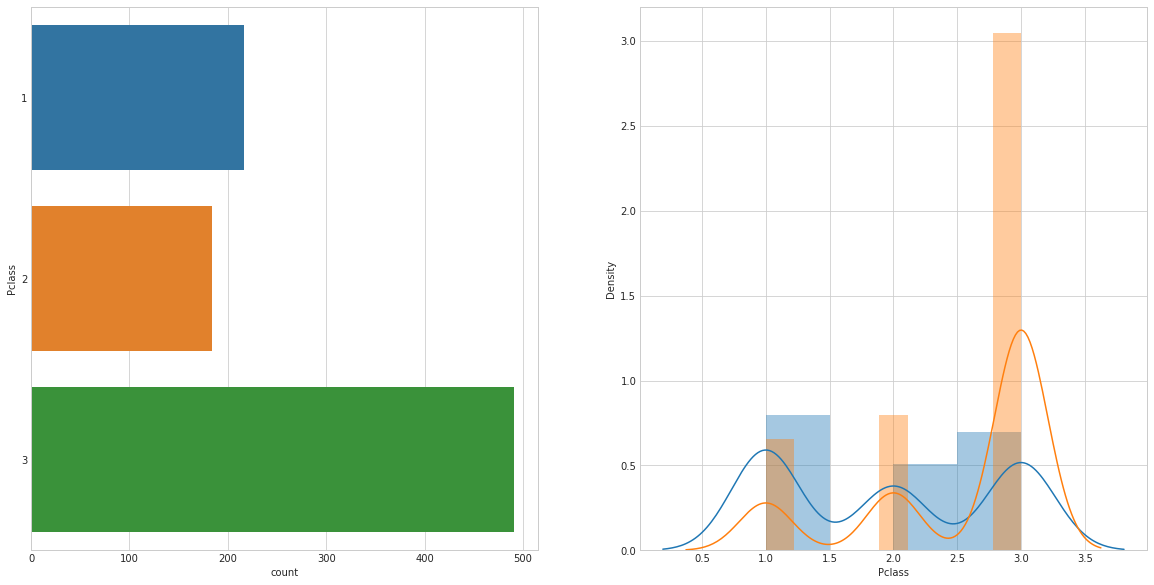

In [16]:
# Visualise the counts of SibSp and the distribution of the values
# against Survived
plot_count_dist(train, 
                bin_df=df_bin, 
                label_column='Survived', 
                target_column='Pclass', 
                figsize=(20, 10))

In [17]:
df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']
df_bin_test['Pclass'] = test['Pclass']
df_bin.head()

,Survived,Pclass
0,0,3
1,1,1
2,1,3
3,1,1
4,0,3


#### Name

In [18]:
# name
# How many different names are there?

# feature engineer

#### Sex

male      577
female    314
Name: Sex, dtype: int64


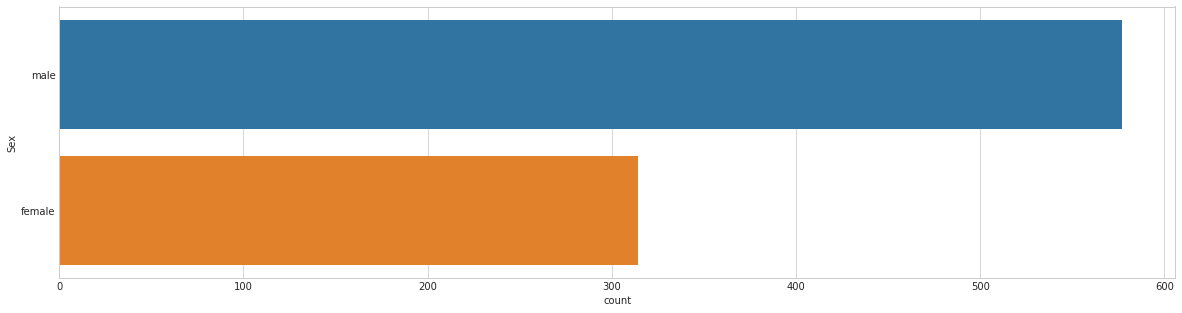

In [19]:
# sex
# Let's view the distribution of Sex
plt.figure(figsize=(20, 5))
sns.countplot(y="Sex", data=train)
print(train.Sex.value_counts())

In [20]:
# add Sex to the subset dataframes
df_bin['Sex'] = train['Sex']
df_bin['Sex'] = np.where(df_bin['Sex'] == 'female', 1, 0) # change sex to 0 for male and 1 for female

df_bin_test['Sex'] = test['Sex']
df_bin_test['Sex'] = np.where(df_bin_test['Sex'] == 'female', 1, 0) # change sex to 0 for male and 1 for female

df_con['Sex'] = train['Sex']

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


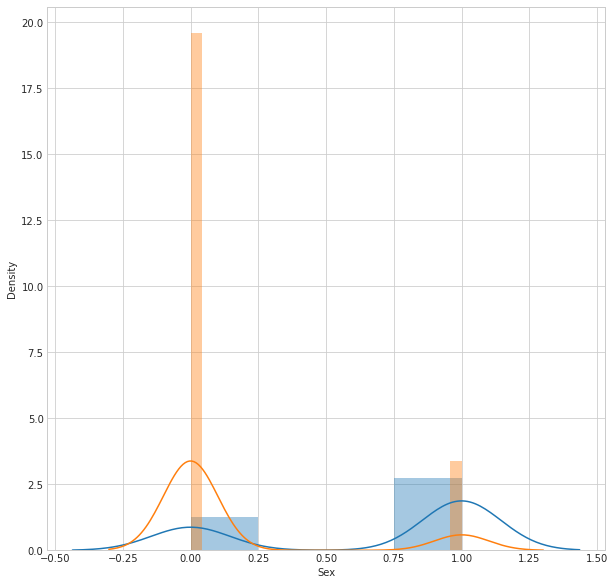

In [21]:
# How does the Sex variable look compared to Survival?
# We can see this because they're both binarys.
fig = plt.figure(figsize=(10, 10))
sns.distplot(df_bin.loc[df_bin['Survived'] == 1]['Sex'], kde_kws={'label': 'Survived'});
sns.distplot(df_bin.loc[df_bin['Survived'] == 0]['Sex'], kde_kws={'label': 'Did not survive'});

In [22]:
# Are there any missing values in the Sex column?
train.Sex.isnull().sum()

0

In [23]:
train.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object

#### Age

In [24]:
train.Age.isnull().sum()

177

In [25]:
train.Age.value_counts()

24.00    30
22.00    27
18.00    26
19.00    25
28.00    25
30.00    25
21.00    24
25.00    23
36.00    22
29.00    20
32.00    18
35.00    18
27.00    18
26.00    18
16.00    17
31.00    17
20.00    15
34.00    15
33.00    15
23.00    15
39.00    14
40.00    13
17.00    13
42.00    13
45.00    12
38.00    11
50.00    10
2.00     10
4.00     10
44.00     9
48.00     9
47.00     9
54.00     8
9.00      8
1.00      7
51.00     7
14.00     6
52.00     6
37.00     6
49.00     6
41.00     6
3.00      6
58.00     5
15.00     5
43.00     5
62.00     4
56.00     4
5.00      4
11.00     4
60.00     4
8.00      4
6.00      3
46.00     3
61.00     3
65.00     3
7.00      3
10.00     2
64.00     2
13.00     2
63.00     2
30.50     2
57.00     2
70.00     2
0.75      2
71.00     2
59.00     2
0.83      2
40.50     2
55.00     2
32.50     2
28.50     2
45.50     2
34.50     1
0.42      1
0.67      1
66.00     1
24.50     1
80.00     1
20.50     1
53.00     1
14.50     1
70.50     1
12.00     1
36.5

#### Sibsp

In [26]:
# What values are there?
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [27]:
# Add SibSp to subset dataframes
df_bin['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

df_bin_test['SibSp'] = test['SibSp']

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


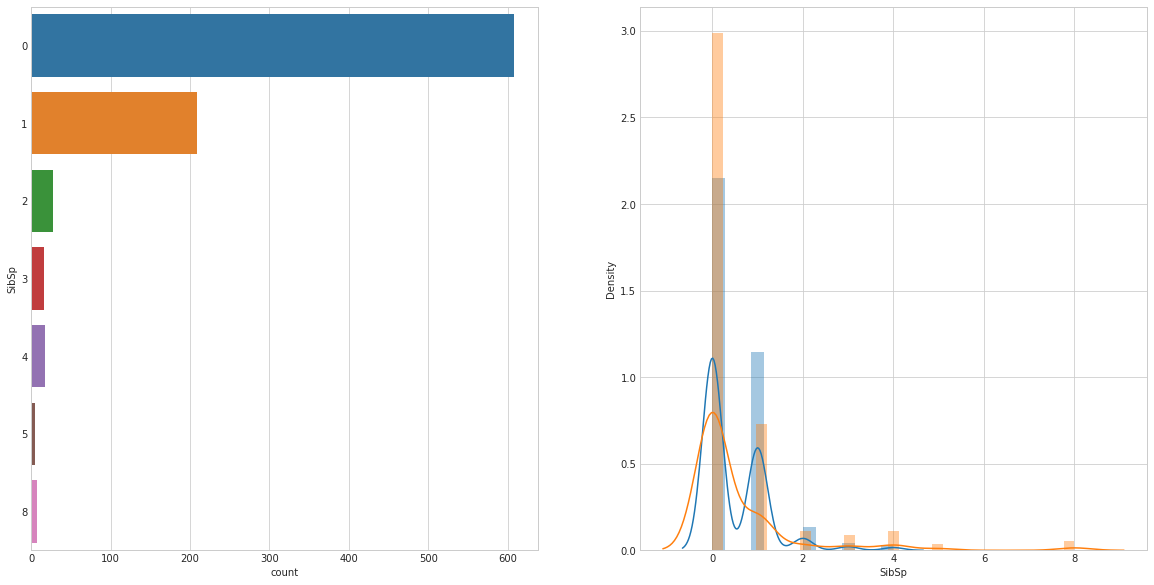

In [28]:
# Visualise the counts of SibSp and the distribution of the values
# against Survived
plot_count_dist(train, 
                bin_df=df_bin, 
                label_column='Survived', 
                target_column='SibSp', 
                figsize=(20, 10))

#### Parch

In [29]:
# What values are there?
train.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [30]:
# Add Parch to subset dataframes
df_bin['Parch'] = train['Parch']
df_con['Parch'] = train['Parch']

df_bin_test['Parch'] = test['Parch']

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


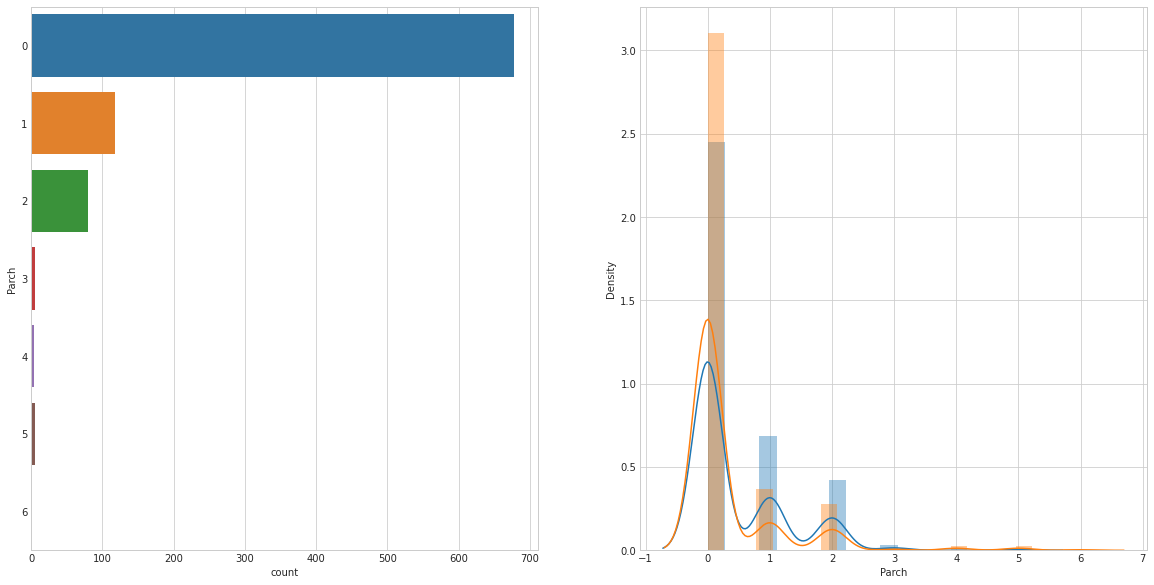

In [31]:
# Visualise the counts of Parch and the distribution of the values
# against Survived
plot_count_dist(train, 
                bin_df=df_bin,
                label_column='Survived', 
                target_column='Parch', 
                figsize=(20, 10))

#### Ticket

<AxesSubplot:xlabel='count', ylabel='Ticket'>

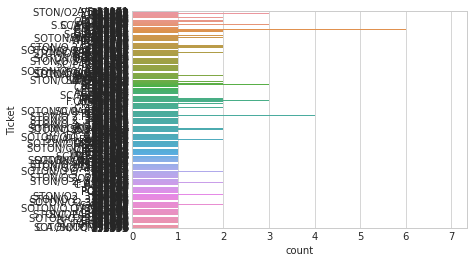

In [32]:
# How many kinds of ticket are there?
sns.countplot(y="Ticket", data=train)

In [33]:
# How many kinds of ticket are there?
train.Ticket.value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

In [34]:
# How many unique kinds of Ticket are there?
print("There are {} unique Ticket values.".format(len(train.Ticket.unique())))

There are 681 unique Ticket values.


#### Fare

<AxesSubplot:xlabel='count', ylabel='Fare'>

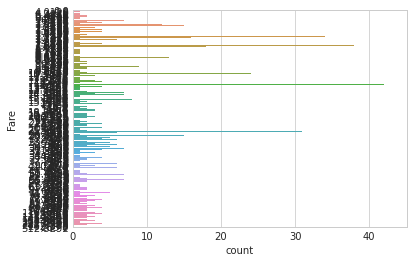

In [35]:
# How many different values of Fare are there?
sns.countplot(y="Fare", data=train)

In [36]:
# What kind of variable is Fare?
train.Fare.dtype

dtype('float64')

In [37]:
# How many unique kinds of Fare are there?
print("There are {} unique Fare values.".format(len(train.Fare.unique())))

There are 248 unique Fare values.


In [38]:
# Add Fare to sub dataframes
df_con['Fare'] = train['Fare'] 
df_bin['Fare'] = pd.cut(train['Fare'], bins=5) # discretised

df_bin_test['Fare'] = test['Fare']
df_bin_test['Fare'] = pd.cut(test['Fare'], bins=5) # discretised
# What do our Fare bins look like?
df_bin.Fare.value_counts()

(-0.512, 102.466]     838
(102.466, 204.932]     33
(204.932, 307.398]     17
(409.863, 512.329]      3
(307.398, 409.863]      0
Name: Fare, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


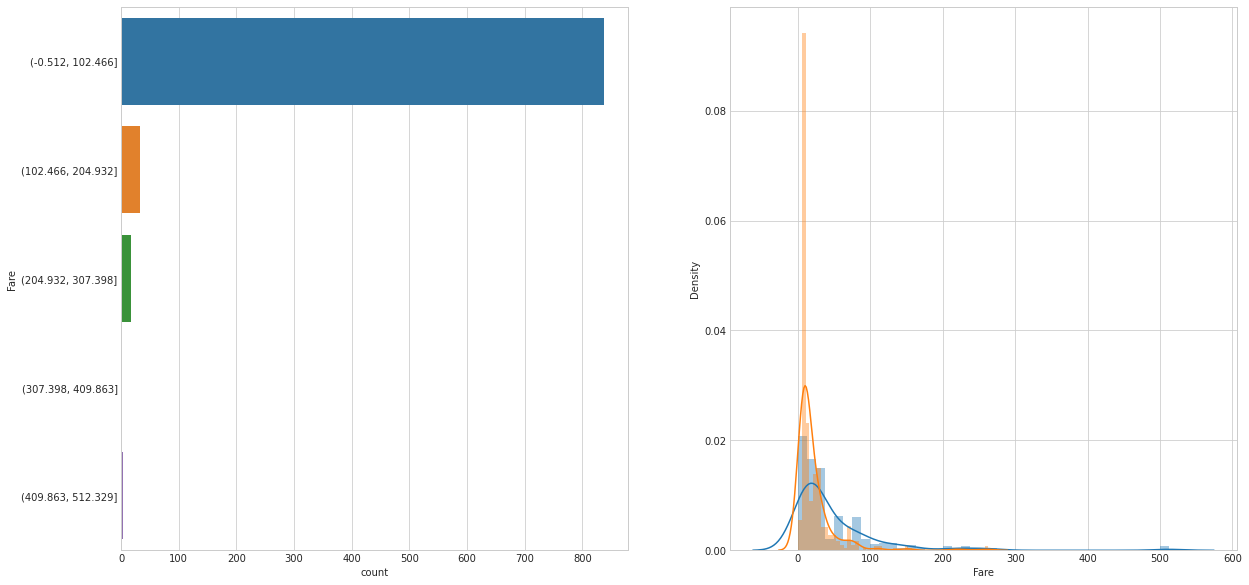

In [39]:
# Visualise the Fare bin counts as well as the Fare distribution versus Survived.
plot_count_dist(data=train,
                bin_df=df_bin,
                label_column='Survived', 
                target_column='Fare', 
                figsize=(20,10), 
                use_bin_df=True)

#### Cabin

In [40]:
# How many missing values does Cabin have?
train.Cabin.isnull().sum()

687

In [41]:
# What do the Cabin values look like?
train.Cabin.value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

#### Embarked

In [42]:
# How many missing values does Embarked have?
train.Embarked.isnull().sum()

2

In [43]:
# What kind of values are in Embarked?
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

<AxesSubplot:xlabel='count', ylabel='Embarked'>

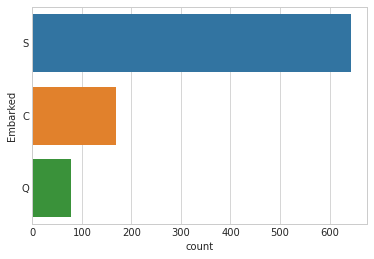

In [44]:
# What do the counts look like?
sns.countplot(y='Embarked', data=train)

In [45]:
# Add Embarked to sub dataframes
df_bin['Embarked'] = train['Embarked']
df_con['Embarked'] = train['Embarked']
df_bin_test['Embarked'] = test['Embarked']

In [46]:
df_bin.head(2)

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,0,1,0,"(-0.512, 102.466]",S
1,1,1,1,1,0,"(-0.512, 102.466]",C


In [47]:
df_con.head(2)

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,male,1,0,7.2500,S
1,1,1,female,1,0,71.2833,C


In [48]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


## Data Cleaning - impute data or remove it (age, cabin, embarked)

In [49]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [50]:
# Remove Embarked rows which are missing values
print(len(df_con))
df_con = df_con.dropna(subset=['Embarked'])
df_bin = df_bin.dropna(subset=['Embarked'])

df_bin_test = df_bin_test.dropna(subset=['Fare'])
print(len(df_con))

891
889


In [51]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [52]:
train['Age']

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888     NaN
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64

In [53]:
train['Age'].fillna((train['Age'].median()), inplace=True)
test['Age'].fillna((test['Age'].median()), inplace=True)

train.Age.isnull().sum()

0

In [54]:
# Once the Age values have been fixed up, we can add them to our sub dataframes.
#df_bin['Age'] = pd.cut(train['Age'], 10) # bucketed/binned into different categories
#df_bin_test['Age'] = pd.cut(test['Age'], 10) # bucketed/binned into different categories
#df_con['Age'] = train['Age'] # non-bucketed

In [55]:
# ignore cabin for now

## Correlation between metrics

In [56]:
df_bin.corr()
# look at correlation between features. this is really useful for regresssion when we don't want to have to use 2 features that are very closely connected

,Survived,Pclass,Sex,SibSp,Parch
Survived,1.000000,-0.335549,0.541585,-0.034040,0.083151
Pclass,-0.335549,1.000000,-0.127741,0.081656,0.016824
Sex,0.541585,-0.127741,1.000000,0.116348,0.247508
SibSp,-0.034040,0.081656,0.116348,1.000000,0.414542
Parch,0.083151,0.016824,0.247508,0.414542,1.000000


<AxesSubplot:>

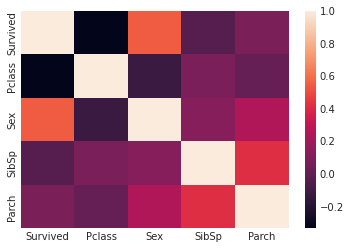

In [57]:
sns.heatmap(df_bin.corr())

## Feature Engineering - (name, ticket, cabin)

In [58]:
# ignore ticket
#ignore cabin
# feature engineering on person's title
train['Name_Title'] = train.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
test['Name_Title'] = test.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
train['Name_Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Name_Title, dtype: int64

In [59]:
Name_title_survival = pd.pivot_table(train, index = 'Survived', columns = ['Name_Title'], values = 'Ticket', aggfunc = 'count').reset_index()
Name_title_survival.loc['sum'] = Name_title_survival.iloc[0] + Name_title_survival.iloc[1]
Name_title_survival.loc['survival_percentage'] = Name_title_survival.iloc[1] / Name_title_survival.iloc[2]
Name_title_survival

Name_Title,Survived,Capt,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
0,0.0,1.0,1.0,1.0,4.000000,1.0,NaN,1.0,17.000,55.000000,NaN,NaN,436.000000,26.000,NaN,6.0,NaN,NaN
1,1.0,NaN,1.0,NaN,3.000000,NaN,1.0,1.0,23.000,127.000000,2.0,1.0,81.000000,99.000,1.0,NaN,1.0,1.0
sum,1.0,NaN,2.0,NaN,7.000000,NaN,NaN,2.0,40.000,182.000000,NaN,NaN,517.000000,125.000,NaN,NaN,NaN,NaN
survival_percentage,1.0,NaN,0.5,NaN,0.428571,NaN,NaN,0.5,0.575,0.697802,NaN,NaN,0.156673,0.792,NaN,NaN,NaN,NaN


In [60]:
train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,Mr


In [61]:
# Add Name_Title to sub dataframes
df_bin['Name_Title'] = train['Name_Title']
df_bin_test['Name_Title'] = test['Name_Title']
df_con['Name_Title'] = train['Name_Title']

In [62]:
df_bin.head(1)

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Name_Title
0,0,3,0,1,0,"(-0.512, 102.466]",S,Mr


## Data pre-processing for model
    pr-process data together or use a transformer


In [63]:
# encode our binned dataframe (df_bin) with one-hot encoding and our continuous dataframe (df_con) with the label encoding function from sklearn.
df_bin.head(1)

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Name_Title
0,0,3,0,1,0,"(-0.512, 102.466]",S,Mr


In [64]:
# One-hot encode binned variables
one_hot_cols = df_bin.columns.tolist()
one_hot_cols.remove('Survived')
df_bin_enc = pd.get_dummies(df_bin, columns=one_hot_cols)

df_bin_enc.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,"Fare_(-0.512, 102.466]","Fare_(102.466, 204.932]","Fare_(204.932, 307.398]","Fare_(307.398, 409.863]","Fare_(409.863, 512.329]",Embarked_C,Embarked_Q,Embarked_S,Name_Title_Capt,Name_Title_Col,Name_Title_Don,Name_Title_Dr,Name_Title_Jonkheer,Name_Title_Lady,Name_Title_Major,Name_Title_Master,Name_Title_Miss,Name_Title_Mlle,Name_Title_Mme,Name_Title_Mr,Name_Title_Mrs,Name_Title_Ms,Name_Title_Rev,Name_Title_Sir,Name_Title_the Countess
0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [65]:
df_bin_test.head(1)

,Pclass,Sex,SibSp,Parch,Fare,Embarked,Name_Title
0,3,0,0,0,"(-0.512, 102.466]",Q,Mr


In [66]:
# One-hot encode binned variables
one_hot_cols = df_bin_test.columns.tolist()
#one_hot_cols.remove('Survived')
df_bin_enc_test = pd.get_dummies(df_bin_test, columns=one_hot_cols)

df_bin_enc_test.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9,"Fare_(-0.512, 102.466]","Fare_(102.466, 204.932]","Fare_(204.932, 307.398]","Fare_(307.398, 409.863]","Fare_(409.863, 512.329]",Embarked_C,Embarked_Q,Embarked_S,Name_Title_Col,Name_Title_Dona,Name_Title_Dr,Name_Title_Master,Name_Title_Miss,Name_Title_Mr,Name_Title_Mrs,Name_Title_Ms,Name_Title_Rev
0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0


In [67]:
X_train = df_bin_enc.drop(['Survived'], axis=1)
X_test = df_bin_enc_test
y_train = df_bin_enc['Survived']

In [68]:
train_cols = X_train.columns
test_cols = X_test.columns

common_cols = train_cols.intersection(test_cols)
train_not_test = train_cols.difference(test_cols)

train_not_test

Index(['Name_Title_Capt', 'Name_Title_Don', 'Name_Title_Jonkheer', 'Name_Title_Lady', 'Name_Title_Major', 'Name_Title_Mlle', 'Name_Title_Mme', 'Name_Title_Sir', 'Name_Title_the Countess'], dtype='object')

In [69]:
X_train = X_train.drop(['Name_Title_Capt', 'Name_Title_Don', 'Name_Title_Jonkheer', 'Name_Title_Lady', 'Name_Title_Major', 'Name_Title_Mlle', 'Name_Title_Mme', 'Name_Title_Sir', 'Name_Title_the Countess'], axis=1)

In [70]:
train['train_test'] = 1
test['train_test'] = 0
test['Survived'] = np.NaN
all_data = pd.concat([train,test])

(889,)

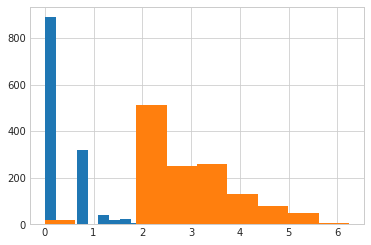

In [71]:
#create all categorical variables that we did above for both training and test sets 
all_data['cabin_multiple'] = all_data.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
all_data['cabin_adv'] = all_data.Cabin.apply(lambda x: str(x)[0])
all_data['numeric_ticket'] = all_data.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
all_data['ticket_letters'] = all_data.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)
all_data['name_title'] = all_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

#impute nulls for continuous data 
#all_data.Age = all_data.Age.fillna(train.Age.mean())
all_data.Age = all_data.Age.fillna(train.Age.median())
#all_data.Fare = all_data.Fare.fillna(train.Fare.mean())
all_data.Fare = all_data.Fare.fillna(train.Fare.median())

#drop null 'embarked' rows. Only 2 instances of this in training and 0 in test 
all_data.dropna(subset=['Embarked'],inplace = True)

#tried log norm of sibsp (not used)
all_data['norm_sibsp'] = np.log(all_data.SibSp+1)
all_data['norm_sibsp'].hist()

# log norm of fare (used)
all_data['norm_fare'] = np.log(all_data.Fare+1)
all_data['norm_fare'].hist()

# converted fare to category for pd.get_dummies()
all_data.Pclass = all_data.Pclass.astype(str)

#created dummy variables from categories (also can use OneHotEncoder)
all_dummies = pd.get_dummies(all_data[['Pclass','Sex','Age','SibSp','Parch','norm_fare','Embarked','cabin_adv','cabin_multiple','numeric_ticket','name_title','train_test']])

#Split to train test again
X_train = all_dummies[all_dummies.train_test == 1].drop(['train_test'], axis =1)
X_test = all_dummies[all_dummies.train_test == 0].drop(['train_test'], axis =1)


y_train = all_data[all_data.train_test==1].Survived
y_train.shape

In [72]:
# Scale data 
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
all_dummies_scaled = all_dummies.copy()
all_dummies_scaled[['Age','SibSp','Parch','norm_fare']]= scale.fit_transform(all_dummies_scaled[['Age','SibSp','Parch','norm_fare']])
all_dummies_scaled

X_train_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 1].drop(['train_test'], axis =1)
X_test_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 0].drop(['train_test'], axis =1)

y_train = all_data[all_data.train_test==1].Survived


##  Model Building

In [73]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

##### Naive

In [74]:
# Naive Bayes as a baseline for my classification tasks 
gnb = GaussianNB()
cv = cross_val_score(gnb,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.66853933 0.70224719 0.76966292 0.75842697 0.72881356]
0.7255379927632831


##### Logistic Regression

In [75]:
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.8258427  0.80898876 0.80337079 0.82022472 0.85310734]
0.8223068621849807


##### Decision Tree

In [76]:
dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.75842697 0.74719101 0.8258427  0.74719101 0.8079096 ]
0.7773122579826065


##### K nearest neughbour

In [77]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.76966292 0.79775281 0.80898876 0.82022472 0.85310734]
0.8099473116231829


##### Random Forest

In [78]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.80898876 0.79213483 0.84831461 0.73595506 0.82485876]
0.8020504030978227


##### Support Vector Machine

In [79]:
svc = SVC(probability = True)
cv = cross_val_score(svc,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.69101124 0.76966292 0.71348315 0.71910112 0.74011299]
0.7266742842633149


In [80]:
#Voting classifier takes all of the inputs and averages the results. For a "hard" voting classifier each classifier gets 1 vote "yes" or "no" and the result is just a popular vote. For this, you generally want odd numbers
#A "soft" classifier averages the confidence of each of the models. If a the average confidence is > 50% that it is a 1 it will be counted as such
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators = [('lr',lr),('knn',knn),('rf',rf),('gnb',gnb),('svc',svc)], voting = 'soft') 

In [81]:
cv = cross_val_score(voting_clf,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.78651685 0.78651685 0.80898876 0.79775281 0.85875706]
0.8077064686091537


In [82]:
voting_clf.fit(X_train,y_train)
y_hat_base_vc = voting_clf.predict(X_test).astype(int)
basic_submission = {'PassengerId': test.PassengerId, 'Survived': y_hat_base_vc}
base_submission = pd.DataFrame(data=basic_submission)
base_submission.to_csv('base_submission.csv', index=False)

## Model Tuning

## Ensemble Model Building

## Results

In [83]:
#convert output to dataframe 
final_data = {'PassengerId': test.PassengerId, 'Survived': y_hat_base_vc}
submission = pd.DataFrame(data=final_data)

In [84]:
#prepare submission files 
submission.to_csv('submission_rf.csv', index =False)